### ReAct Agent Architecture

#### Aim
This is the intuition behind ReAct, a general agent architecture.

1. act - let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)



In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention iss all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [7]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

✓ Gemini model initialized for reranking


/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]

In [9]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [10]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'Top 5 AI trends in March 2025: AI agents, smarter supply ...',
  'url': 'https://www.neudesic.com/blog/top-5-ai-trends-march-2025/',
  'content': 'March 2025 has brought a fresh wave of AI innovations that go beyond theoretical breakthroughs and translate directly into real-world impact. From OpenAI’s newly released tools for building AI agents to Microsoft’s external knowledge integration approach, this month’s highlights underscore how artificial intelligence is evolving in ways that matter today, not just tomorrow. Whether it’s optimizing supply chains, pushing the limits of robotics, or making AI systems smarter and more trustworthy, [...] Below, we delve into five top AI trends from March 2025 and explore the practical ways they’re changing industries—from retail to robotics—and setting the stage for what’s ahead. \n\n## 1. OpenAI Releases New Tools for Building AI Agents [...] natural way in a variety of domains.  The investment in physical AI, like Gemini Robotics, h

In [11]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily,add,divide,multiply]

In [12]:
llm_with_tools=llm.bind_tools(tools)

In [13]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "recent AI News"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--c1f64a86-bdf5-477a-8bba-18d4ce87cd42-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI News'}, 'id': '6ce8456f-6d0b-4a1f-9b09-390bc451507c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 12, 'total_tokens': 226, 'input_token_details': {'cache_read': 0}})

In [14]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI News'},
  'id': 'c3269912-97f2-42ad-803a-16611055f4d6',
  'type': 'tool_call'}]

In [15]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

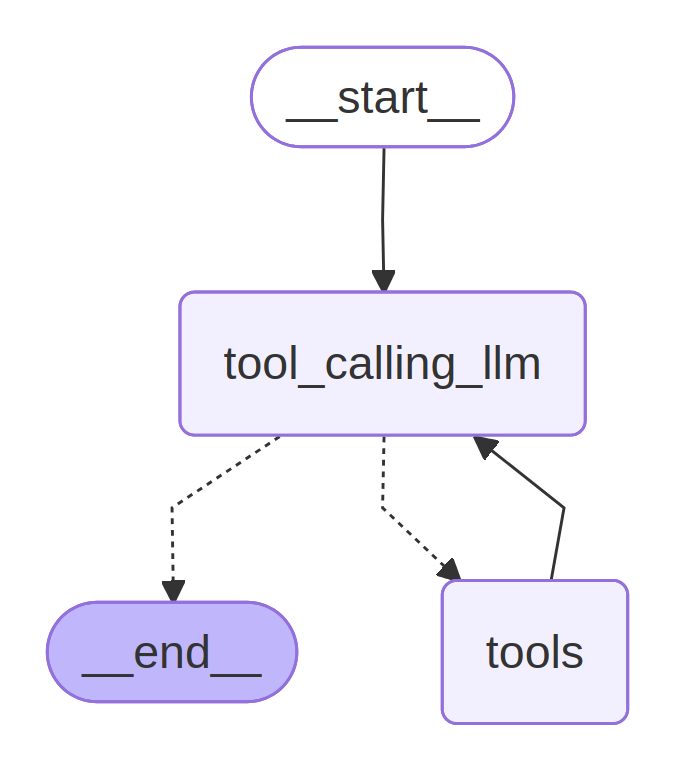

In [ ]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
    {
        "tools": "tools",  # If agent wants tools → go to tools node
        END: END,          # If agent doesn't need tools → end workflow
    }
)
builder.add_edge("tools","tool_calling_llm")
builder.add_edge("tool_calling_llm", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))


In [26]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 5 recent AI news for March 3rd 2025,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 5 recent AI news for March 3rd 2025,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8c742d43-a542-4099-bc4d-239a04004348)
 Call ID: 8c742d43-a542-4099-bc4d-239a04004348
  Args:
    query: AI news March 3rd 2025
  add (f58746ce-973a-4cf7-93d1-5e1739f0ace8)
 Call ID: f58746ce-973a-4cf7-93d1-5e1739f0ace8
  Args:
    a: 5.0
    b: 5.0
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weekly AI News: 3 March 2025 - AIforBusiness.net - YouTube", "url": "https://www.youtube.com/watch?v=kw21NJ7YmZM", "content": "This week’s AI update explores some of the most impactful developments shaping technology and society. OpenAI has unveiled GPT-4.5, a cutting-edge model with enhanced intuition and emotional intellige

In [21]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (1fc2d2ed-11e1-4916-8072-b35a67d98d4e)
 Call ID: 1fc2d2ed-11e1-4916-8072-b35a67d98d4e
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message =====================

### Agent Memory
#### Aim
Introduction to Agent With Memory

In [27]:
messages=graph.invoke({"messages":HumanMessage(content="What is 5 plus 8")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 8
================================== Ai Message ==================================
Tool Calls:
  add (ca7528e0-f3c7-43e4-b4d0-016de567ade6)
 Call ID: ca7528e0-f3c7-43e4-b4d0-016de567ade6
  Args:
    a: 5.0
    b: 8.0
================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

5 plus 8 is 13.


In [28]:
messages=[HumanMessage(content="Divide that by 5")]
messages=graph.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

I need more information to divide. Please provide the number you would like to divide by 5.


#### MemorySaver
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

![image.png](attachment:image.png)

In [29]:
llm_with_tools = llm.bind_tools(tools)

In [32]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")
builder.add_edge("tool_calling_llm", END)




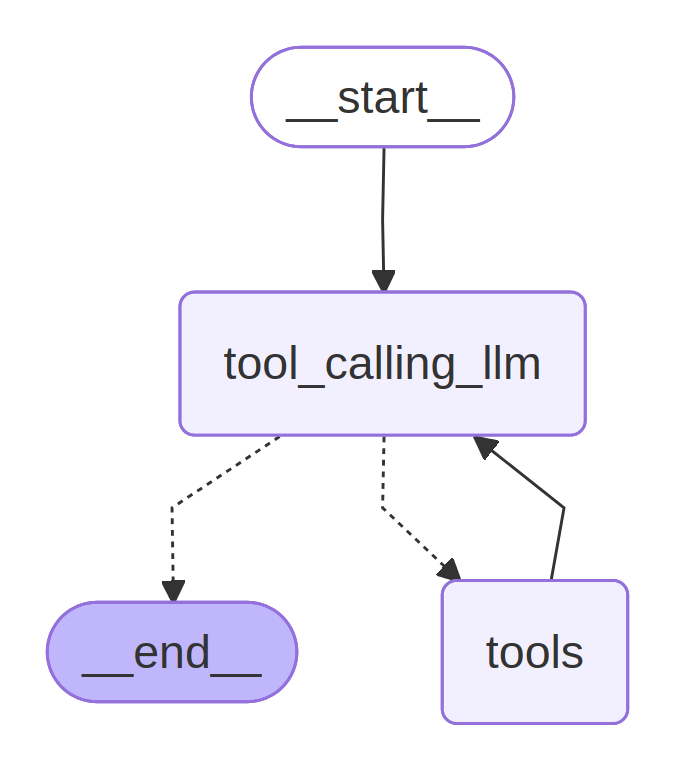

In [33]:
import nest_asyncio
nest_asyncio.apply()

from langgraph.checkpoint.memory import MemorySaver


memory=MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# View
display(Image(graph_memory.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [34]:
## Specify the thread

config={"configurable":{"thread_id":"1"}}
# Specify an input
messages = [HumanMessage(content="Add 12 and 13.")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (c830cfc2-3c83-4aa4-b37f-3d3b95e870a8)
 Call ID: c830cfc2-3c83-4aa4-b37f-3d3b95e870a8
  Args:
    a: 12.0
    b: 13.0
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.


In [35]:
messages = [HumanMessage(content="add that number to 25")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (c830cfc2-3c83-4aa4-b37f-3d3b95e870a8)
 Call ID: c830cfc2-3c83-4aa4-b37f-3d3b95e870a8
  Args:
    a: 12.0
    b: 13.0
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (74813783-07ae-497f-9593-8cfea361cb19)
 Call ID: 74813783-07ae-497f-9593-8cfea361cb19
  Args:
    a: 25.0
    b: 25.0
================================= Tool Message =================================
Name: add

50
================================== Ai Message ===================

In [36]:
messages = [HumanMessage(content="then multiplty that number by 2")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (c830cfc2-3c83-4aa4-b37f-3d3b95e870a8)
 Call ID: c830cfc2-3c83-4aa4-b37f-3d3b95e870a8
  Args:
    a: 12.0
    b: 13.0
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (74813783-07ae-497f-9593-8cfea361cb19)
 Call ID: 74813783-07ae-497f-9593-8cfea361cb19
  Args:
    a: 25.0
    b: 25.0
================================= Tool Message =================================
Name: add

50
================================== Ai Message ===================